# Practical 6
Implement decision trees and Naive Bayes classifiers from scratch on a real dataset, visualize the resulting decision boundaries and tree structures, and summarize the results.

## Load and preprocess data


In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target)

# Inspect the dataset - check for missing values and data types
print("Missing values per column:")
print(X.isnull().sum())
print("\nData types:")
print(X.dtypes)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Missing values per column:
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

Data types:
mean radius                float64
mean texture               float64
mean pe

## Implement decision tree

In [2]:
import numpy as np
from collections import Counter

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, impurity_measure='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.impurity_measure = impurity_measure
        self.tree = None

    def _calculate_impurity(self, y):
        if self.impurity_measure == 'gini':
            return self._gini_impurity(y)
        elif self.impurity_measure == 'entropy':
            return self._entropy(y)
        else:
            raise ValueError("Invalid impurity measure specified.")

    def _gini_impurity(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        gini = 1 - np.sum(probabilities**2)
        return gini

    def _entropy(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10)) # Add epsilon to avoid log(0)
        return entropy

    def _best_split(self, X, y):
        best_gini = float('inf')
        best_split_feature_index = None
        best_split_value = None

        n_samples, n_features = X.shape

        if n_samples < self.min_samples_split:
            return None, None

        parent_impurity = self._calculate_impurity(y)

        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = np.where(X[:, feature_index] <= threshold)[0]
                right_indices = np.where(X[:, feature_index] > threshold)[0]

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                y_left, y_right = y[left_indices], y[right_indices]

                gini_left = self._calculate_impurity(y_left)
                gini_right = self._calculate_impurity(y_right)

                weighted_gini = (len(left_indices) / n_samples) * gini_left + (len(right_indices) / n_samples) * gini_right

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_split_feature_index = feature_index
                    best_split_value = threshold

        if best_gini >= parent_impurity: # Only split if there is an improvement
            return None, None

        return best_split_feature_index, best_split_value

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping conditions
        if (self.max_depth is not None and depth >= self.max_depth) or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return {'leaf': leaf_value}

        best_split_feature_index, best_split_value = self._best_split(X, y)

        if best_split_feature_index is None:
            leaf_value = self._most_common_label(y)
            return {'leaf': leaf_value}

        left_indices = np.where(X[:, best_split_feature_index] <= best_split_value)[0]
        right_indices = np.where(X[:, best_split_feature_index] > best_split_value)[0]

        left_subtree = self._build_tree(X[left_indices, :], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices, :], y[right_indices], depth + 1)

        return {'feature_index': best_split_feature_index,
                'split_value': best_split_value,
                'left': left_subtree,
                'right': right_subtree}

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def fit(self, X, y):
        self.tree = self._build_tree(X.values, y.values, depth=0)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X.values])

    def _traverse_tree(self, x, node):
        if 'leaf' in node:
            return node['leaf']

        feature_index = node['feature_index']
        split_value = node['split_value']

        if x[feature_index] <= split_value:
            return self._traverse_tree(x, node['left'])
        else:
            return self._traverse_tree(x, node['right'])


## Implement naive bayes


In [3]:
import numpy as np

class NaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # Calculate prior probabilities
        self._priors = np.zeros(n_classes)
        for i, c in enumerate(self._classes):
            self._priors[i] = np.sum(y == c) / n_samples

        # Calculate mean, variance, and standard deviation for each feature and class
        self._means = np.zeros((n_classes, n_features))
        self._variances = np.zeros((n_classes, n_features))

        for i, c in enumerate(self._classes):
            X_c = X[y == c]
            self._means[i, :] = X_c.mean(axis=0)
            self._variances[i, :] = X_c.var(axis=0)

        # Add a small epsilon to variance to prevent division by zero
        self._variances += 1e-9

    def _gaussian_pdf(self, x, mean, variance):
        numerator = np.exp(-((x - mean)**2) / (2 * variance))
        denominator = np.sqrt(2 * np.pi * variance)
        return numerator / denominator

    def predict(self, X):
        y_pred = [self._predict(x) for x in X.values]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        for i, c in enumerate(self._classes):
            prior = np.log(self._priors[i])
            class_conditional_likelihood = np.sum(np.log(self._gaussian_pdf(x, self._means[i, :], self._variances[i, :])))
            posterior = prior + class_conditional_likelihood
            posteriors.append(posterior)

        return self._classes[np.argmax(posteriors)]


## Train and evaluate models


In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score

# Load the dataset
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, impurity_measure='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.impurity_measure = impurity_measure
        self.tree = None

    def _calculate_impurity(self, y):
        if self.impurity_measure == 'gini':
            return self._gini_impurity(y)
        elif self.impurity_measure == 'entropy':
            return self._entropy(y)
        else:
            raise ValueError("Invalid impurity measure specified.")

    def _gini_impurity(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        gini = 1 - np.sum(probabilities**2)
        return gini

    def _entropy(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10)) # Add epsilon to avoid log(0)
        return entropy

    def _best_split(self, X, y):
        best_gini = float('inf')
        best_split_feature_index = None
        best_split_value = None

        n_samples, n_features = X.shape

        if n_samples < self.min_samples_split:
            return None, None

        parent_impurity = self._calculate_impurity(y)

        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = np.where(X[:, feature_index] <= threshold)[0]
                right_indices = np.where(X[:, feature_index] > threshold)[0]

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                y_left, y_right = y[left_indices], y[right_indices]

                gini_left = self._calculate_impurity(y_left)
                gini_right = self._calculate_impurity(y_right)

                weighted_gini = (len(left_indices) / n_samples) * gini_left + (len(right_indices) / n_samples) * gini_right

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_split_feature_index = feature_index
                    best_split_value = threshold

        if best_gini >= parent_impurity: # Only split if there is an improvement
            return None, None

        return best_split_feature_index, best_split_value

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping conditions
        if (self.max_depth is not None and depth >= self.max_depth) or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return {'leaf': leaf_value}

        best_split_feature_index, best_split_value = self._best_split(X, y)

        if best_split_feature_index is None:
            leaf_value = self._most_common_label(y)
            return {'leaf': leaf_value}

        left_indices = np.where(X[:, best_split_feature_index] <= best_split_value)[0]
        right_indices = np.where(X[:, best_split_feature_index] > best_split_value)[0]

        left_subtree = self._build_tree(X[left_indices, :], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices, :], y[right_indices], depth + 1)

        return {'feature_index': best_split_feature_index,
                'split_value': best_split_value,
                'left': left_subtree,
                'right': right_subtree}

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def fit(self, X, y):
        self.tree = self._build_tree(X.values, y.values, depth=0)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X.values])

    def _traverse_tree(self, x, node):
        if 'leaf' in node:
            return node['leaf']

        feature_index = node['feature_index']
        split_value = node['split_value']

        if x[feature_index] <= split_value:
            return self._traverse_tree(x, node['left'])
        else:
            return self._traverse_tree(x, node['right'])

class NaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # Calculate prior probabilities
        self._priors = np.zeros(n_classes)
        for i, c in enumerate(self._classes):
            self._priors[i] = np.sum(y == c) / n_samples

        # Calculate mean, variance, and standard deviation for each feature and class
        self._means = np.zeros((n_classes, n_features))
        self._variances = np.zeros((n_classes, n_features))

        for i, c in enumerate(self._classes):
            X_c = X[y == c]
            self._means[i, :] = X_c.mean(axis=0)
            self._variances[i, :] = X_c.var(axis=0)

        # Add a small epsilon to variance to prevent division by zero
        self._variances += 1e-9


    def _gaussian_pdf(self, x, mean, variance):
        numerator = np.exp(-((x - mean)**2) / (2 * variance))
        denominator = np.sqrt(2 * np.pi * variance)
        return numerator / denominator

    def predict(self, X):
        y_pred = [self._predict(x) for x in X.values]
        return np.array(y_pred)


    def _predict(self, x):
        posteriors = []

        for i, c in enumerate(self._classes):
            prior = np.log(self._priors[i])
            class_conditional_likelihood = np.sum(np.log(self._gaussian_pdf(x, self._means[i, :], self._variances[i, :])))
            posterior = prior + class_conditional_likelihood
            posteriors.append(posterior)

        return self._classes[np.argmax(posteriors)]


# 1. Instantiate the classifier classes
dt_classifier = DecisionTree()
nb_classifier = NaiveBayes()

# 2. Train the DecisionTree model
dt_classifier.fit(X_train, y_train)

# 3. Train the NaiveBayes model
nb_classifier.fit(X_train, y_train)

# 4. Use the trained DecisionTree model to make predictions
dt_predictions = dt_classifier.predict(X_test)

# 5. Use the trained NaiveBayes model to make predictions
nb_predictions = nb_classifier.predict(X_test)

# 6. Calculate the accuracy score for the DecisionTree predictions
dt_accuracy = accuracy_score(y_test, dt_predictions)

# 7. Calculate the accuracy score for the NaiveBayes predictions
nb_accuracy = accuracy_score(y_test, nb_predictions)

# 8. Print the accuracy scores
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")

Decision Tree Accuracy: 0.9298
Naive Bayes Accuracy: 0.9649


## Visualize decision tree



In [5]:
def print_tree(node, feature_names, depth=0, prefix="Root: "):
    """Recursively prints the decision tree structure."""
    if 'leaf' in node:
        print("  " * depth + prefix + f"Predict: {node['leaf']}")
        return

    feature_index = node['feature_index']
    split_value = node['split_value']
    feature_name = feature_names[feature_index]

    print("  " * depth + prefix + f"Feature '{feature_name}' <= {split_value:.4f}")

    print_tree(node['left'], feature_names, depth + 1, "True: ")
    print_tree(node['right'], feature_names, depth + 1, "False: ")

# Get the feature names from the original DataFrame
feature_names = X.columns.tolist()

# Visualize the trained decision tree
print("\nDecision Tree Structure:")
print_tree(dt_classifier.tree, feature_names)


Decision Tree Structure:
Root: Feature 'mean concave points' <= 0.0507
  True: Feature 'worst radius' <= 16.7700
    True: Feature 'radius error' <= 0.6061
      True: Feature 'worst smoothness' <= 0.1768
        True: Feature 'smoothness error' <= 0.0033
          True: Feature 'mean texture' <= 18.2200
            True: Predict: 1
            False: Predict: 0
          False: Feature 'worst texture' <= 33.3300
            True: Predict: 1
            False: Feature 'worst texture' <= 33.3700
              True: Predict: 0
              False: Predict: 1
        False: Predict: 0
      False: Feature 'mean smoothness' <= 0.0875
        True: Predict: 1
        False: Predict: 0
    False: Feature 'mean texture' <= 15.7000
      True: Predict: 1
      False: Feature 'concave points error' <= 0.0099
        True: Predict: 0
        False: Predict: 1
  False: Feature 'worst concave points' <= 0.1465
    True: Feature 'worst perimeter' <= 114.3000
      True: Feature 'mean texture' <= 2

## Visualize decision boundaries

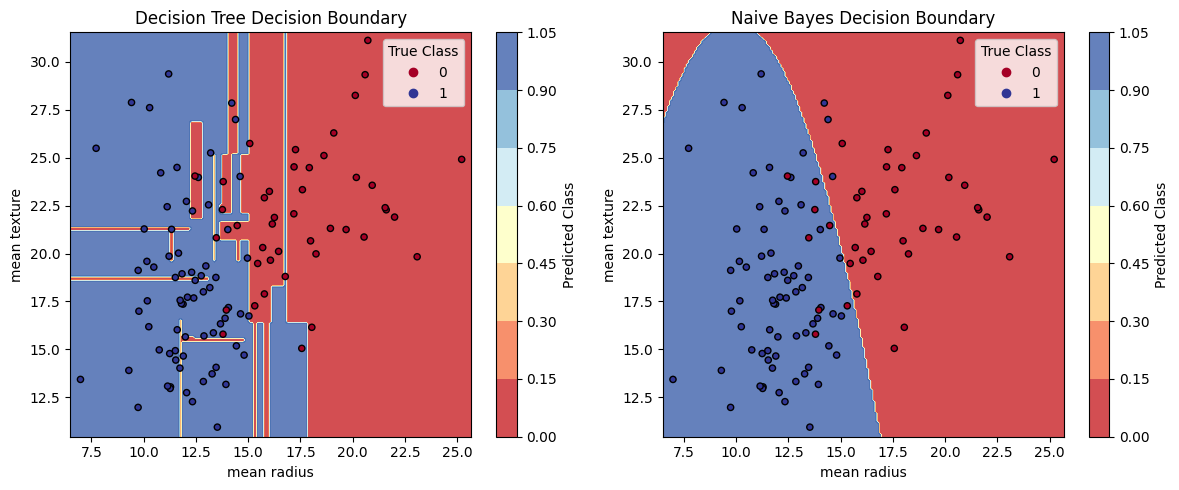

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Select two features for visualization (e.g., the first two features)
feature_index1 = 0 # 'mean radius'
feature_index2 = 1 # 'mean texture'

feature_name1 = X.columns[feature_index1]
feature_name2 = X.columns[feature_index2]

# Use only the selected features for training and testing for visualization purposes
X_train_2features = X_train.iloc[:, [feature_index1, feature_index2]]
X_test_2features = X_test.iloc[:, [feature_index1, feature_index2]]

# Re-train the classifiers on the reduced feature set for accurate boundary plotting
# Note: In a real scenario, you might train on all features and project for visualization,
# but training on the subset directly simplifies the boundary plotting logic here.
dt_classifier_2features = DecisionTree()
nb_classifier_2features = NaiveBayes()

dt_classifier_2features.fit(X_train_2features, y_train)
nb_classifier_2features.fit(X_train_2features, y_train)


# 2. Create a meshgrid based on the selected features from the test set
x_min, x_max = X_test_2features.iloc[:, 0].min() - 0.5, X_test_2features.iloc[:, 0].max() + 0.5
y_min, y_max = X_test_2features.iloc[:, 1].min() - 0.5, X_test_2features.iloc[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Prepare meshgrid for prediction (flatten and combine)
meshgrid_points = np.c_[xx.ravel(), yy.ravel()]
meshgrid_points_df = pd.DataFrame(meshgrid_points, columns=[feature_name1, feature_name2])

# 3. Use the trained Decision Tree classifier to predict
Z_dt = dt_classifier_2features.predict(meshgrid_points_df)
Z_dt = Z_dt.reshape(xx.shape)

# 4. Use the trained Naive Bayes classifier to predict
Z_nb = nb_classifier_2features.predict(meshgrid_points_df)
Z_nb = Z_nb.reshape(xx.shape)

# 5. Create a contour plot for the Decision Tree
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
contour_dt = plt.contourf(xx, yy, Z_dt, cmap=plt.cm.RdYlBu, alpha=0.8)
# 7. Overlay scatter plot of actual test data (Decision Tree)
scatter_dt = plt.scatter(X_test_2features.iloc[:, 0], X_test_2features.iloc[:, 1], c=y_test, cmap=plt.cm.RdYlBu, edgecolors='k', s=20)
# 8. Add titles and labels (Decision Tree)
plt.title('Decision Tree Decision Boundary')
plt.xlabel(feature_name1)
plt.ylabel(feature_name2)
plt.colorbar(contour_dt, label='Predicted Class')
plt.legend(*scatter_dt.legend_elements(), title="True Class")


# 6. Create a contour plot for Naive Bayes
plt.subplot(1, 2, 2)
contour_nb = plt.contourf(xx, yy, Z_nb, cmap=plt.cm.RdYlBu, alpha=0.8)
# 7. Overlay scatter plot of actual test data (Naive Bayes)
scatter_nb = plt.scatter(X_test_2features.iloc[:, 0], X_test_2features.iloc[:, 1], c=y_test, cmap=plt.cm.RdYlBu, edgecolors='k', s=20)
# 8. Add titles and labels (Naive Bayes)
plt.title('Naive Bayes Decision Boundary')
plt.xlabel(feature_name1)
plt.ylabel(feature_name2)
plt.colorbar(contour_nb, label='Predicted Class')
plt.legend(*scatter_nb.legend_elements(), title="True Class")

# 9. Display the plots
plt.tight_layout()
plt.show()

*   On the test set, the custom Decision Tree classifier achieved an accuracy of approximately 0.9298.
*   On the test set, the custom Naive Bayes classifier achieved a higher accuracy of approximately 0.9649.
*   The Naive Bayes classifier outperformed the unpruned Decision Tree on this dataset.